#### 背景说明

当今社会信息技术迅猛发展，每天都会产生海量的信息，在此背景之下，对信息的处理能力就显得尤为重要。绝大多数信息表现为文本形式，那么如何在如此大量且复杂的文本信息中如何获取最有效的信息是信息处理的一大目标。文本分类可以帮助用户准确定位所需信息和分流信息。同时，互联网的快速发展催生了大量的书评影评、网络聊天、产品介绍等形式的短文本，其包含大量有价值的隐含信息，迫切需要自动化工具对短文本进行分类处理。<br>
本项目选取酒店的评价进行文本分类，训练可以识别出不同评价类型的模型。

#### 示例数据

正面评价（1）和负面评价（0）各5000条，储存在csv文件中。
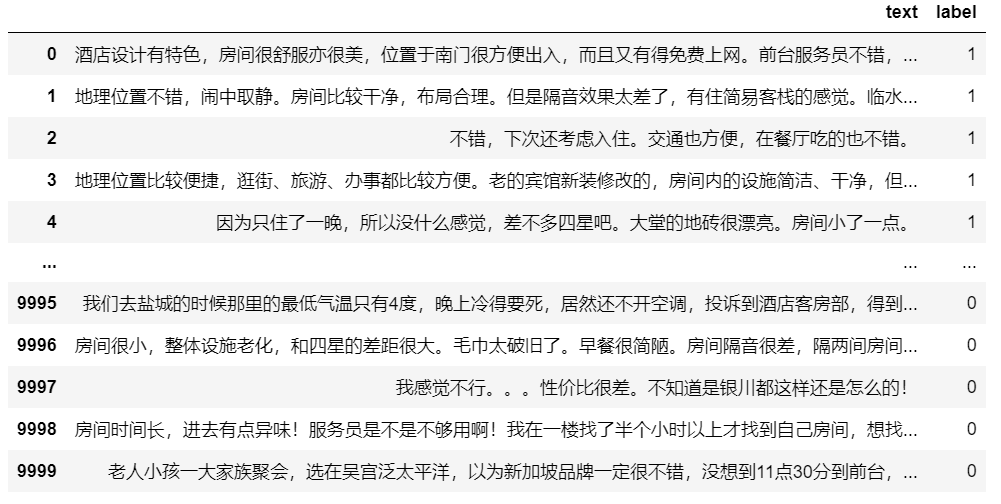

#### 分析思路

对于中文文本，在去停用词之前需要用jieba分词器进行分词处理。分词后的数据使用维基百科训练好的词向量模型进行训练。<br>
1.数据预处理。数据均衡检验，检查空值、重复值。<br>
2.分词、去停用词。对每条文本数据进行分词、去停用词处理。<br>
3.分割数据集。分割数据为训练集和测试集。<br>
4.词向量映射。将文本序列化，并与维基百科训练好的词向量模型进行映射。<br>
5.模型搭建。搭建神经网络模型。<br>
6.模型训练。模型训练<br>
7.模型评估。用sklearn中的混淆矩阵对模型进行评估。

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns
import re
import jieba
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Sequential  
from keras.layers.embeddings import Embedding
from keras.layers import Dropout, Flatten, Dense, LSTM, SpatialDropout1D, Convolution1D, MaxPool1D
from keras.optimizers import adam_v2
import warnings
warnings.filterwarnings("ignore")

2022-12-29 00:39:00.219571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-29 00:39:00.219609: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 数据预处理

In [2]:
#在本地终端ssh外网地址
# 后台运行jupyter，避免中途退出
# nohup jupyter notebook > /dev/null 2>&1 &
# jobs # 测试
# 然后输入外网IP，通过8888端口访问jupyter，密码123456

# 读取文件

df = pd.read_csv('text2cls.csv', index_col=0) ## 读取文件，将第一列设置为索引
df

,text,label
0,酒店设计有特色，房间很舒服亦很美，位置于南门很方便出入，而且又有得免费上网。前台服务员不错，...,1
1,地理位置不错，闹中取静。房间比较干净，布局合理。但是隔音效果太差了，有住简易客栈的感觉。临水...,1
2,不错，下次还考虑入住。交通也方便，在餐厅吃的也不错。,1
3,地理位置比较便捷，逛街、旅游、办事都比较方便。老的宾馆新装修改的，房间内的设施简洁、干净，但...,1
4,因为只住了一晚，所以没什么感觉，差不多四星吧。大堂的地砖很漂亮。房间小了一点。,1
...,...,...
9995,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...,0
9996,房间很小，整体设施老化，和四星的差距很大。毛巾太破旧了。早餐很简陋。房间隔音很差，隔两间房间...,0
9997,我感觉不行。。。性价比很差。不知道是银川都这样还是怎么的！,0
9998,房间时间长，进去有点异味！服务员是不是不够用啊！我在一楼找了半个小时以上才找到自己房间，想找...,0


In [3]:
# 查看各类别的数量

df['label'].value_counts()

1    5000
0    5000
Name: label, dtype: int64

In [4]:
# 检查缺失值

df.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
# 检查重复值

df.duplicated().sum()

0

## 分词、去停用词

In [6]:
# 读取停用词列表
def stopword_list(file):
    with open(file, 'r', encoding='utf-8') as f: # 打开文件
        stopword_list = [w.strip('\n') for w in f.readlines()] # 按行读取停用词并去掉换行符
    return stopword_list
stopwords = stopword_list('stop_word.txt')

In [7]:
# 分词 清除停用语
def clean_stopword(sentence):
    result = ''
    word_list = jieba.cut(sentence) ## jieba分词器进行精确模式分词    
    # 遍历所有词，若在停用词表中则删除
    for word in word_list: 
        if word not in stopwords:
            result += ' '+ word
    return result

In [8]:
# 调用分词函数
jieba.setLogLevel(jieba.logging.INFO) # 关闭日志打印
df['cut_text'] = df['text'].apply(clean_stopword) # 新版dataframe应该要通过df.loc[:,'text']进行查询吧
df

,text,label,cut_text
0,酒店设计有特色，房间很舒服亦很美，位置于南门很方便出入，而且又有得免费上网。前台服务员不错，...,1,酒店设计 特色 房间 舒服 美 位置 南门 出入 免费 上网 前台 服务员 不错 唯 退房...
1,地理位置不错，闹中取静。房间比较干净，布局合理。但是隔音效果太差了，有住简易客栈的感觉。临水...,1,地理位置 不错 闹中取静 房间 干净 布局合理 隔音 效果 太差 有住 简易 客栈 临水 ...
2,不错，下次还考虑入住。交通也方便，在餐厅吃的也不错。,1,不错 下次 入住 交通 餐厅 吃 不错
3,地理位置比较便捷，逛街、旅游、办事都比较方便。老的宾馆新装修改的，房间内的设施简洁、干净，但...,1,地理位置 便捷 逛街 旅游 办事 宾馆 新装 修改 房间内 设施 简洁 干净 宾馆 整体 ...
4,因为只住了一晚，所以没什么感觉，差不多四星吧。大堂的地砖很漂亮。房间小了一点。,1,只住 一晚 没什么 四星 大堂 地砖 房间
...,...,...,...
9995,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...,0,盐城 最低气温 度 晚上 冷得 要死 不开 空调 投诉 酒店客房 部 答复 领导 指示 开...
9996,房间很小，整体设施老化，和四星的差距很大。毛巾太破旧了。早餐很简陋。房间隔音很差，隔两间房间...,0,房间 很小 整体 设施 老化 四星 差距 很大 毛巾 太 破旧 早餐 简陋 房间 隔音 很...
9997,我感觉不行。。。性价比很差。不知道是银川都这样还是怎么的！,0,不行 性价比 很差 银川
9998,房间时间长，进去有点异味！服务员是不是不够用啊！我在一楼找了半个小时以上才找到自己房间，想找...,0,房间 时间 长 异味 服务员 一楼 找 半个 小时 找到 房间 想 找个 服务员 问 找 ...


## 分割数据集

In [9]:
## 利用sklearn分割数据集
x_train, x_test, y_train, y_test = train_test_split(df['cut_text'], df['label'], test_size=0.3, random_state=42) # 测试集比例30%，设置随机种子为42

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000,)
(3000,)
(7000,)
(3000,)


In [10]:
# 类标签的onehot

y_train = pd.get_dummies(y_train).values # 标签进行独热编码
y_test = pd.get_dummies(y_test).values # 标签进行独热编码

## 词向量映射

In [11]:
# 文本序列化
tokenizer = Tokenizer(num_words=1000) # 词个数设置为1000
## 适配文本
tokenizer.fit_on_texts(x_train) # 训练文本
tokenizer.fit_on_texts(x_test) # 训练文本
## 文本序列化
train_seq = tokenizer.texts_to_sequences(x_train) # 文本转为序列
test_seq = tokenizer.texts_to_sequences(x_test) # 文本转为序列
## 截断补齐
train_padding = pad_sequences(train_seq, padding='post', maxlen=50) # 序列长度设置为50
test_padding = pad_sequences(test_seq, padding='post', maxlen=50) # 序列长度设置为50

In [12]:
# 训练好的词向量
def create_embedding_matrix(filepath, word_index, embedding):
    vocab_size = len(word_index) + 1 # 词表大小
    embedding_matrix = np.zeros((vocab_size, 50)) # 创建一个shape为(vocab_size, 50)的0数组
    # 词与词向量进行匹配
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            word, *vector = line.split() # 词，词向量
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:50]
    return embedding_matrix

# 使用维基百科的词向量
embedding_matrix = create_embedding_matrix("chinese_wiki_embeding20000.txt", tokenizer.word_index, 50)

## 模型搭建

In [13]:
# 搭建神经网络

vocab_size=len(tokenizer.index_word) + 1
model = Sequential()
model.add(Embedding(input_dim=vocab_size,  # 词汇表大小为vocab_size
                    output_dim=50, # 词向量维度为50
                    weights=[embedding_matrix], # 指定weights
                    input_length=50, # 输入序列的长度为50
                    trainable=True))
model.add(LSTM(64, return_sequences=True)) ## LSTM层
model.add(Convolution1D(32, 5, padding='same', strides=1, activation='relu')) ## 1为卷积，进行补0操作，激活函数设置为relu
model.add(MaxPool1D(pool_size=3)) ## 1维最大池化
model.add(Flatten()) # 平铺层
model.add(Dense(64, activation='relu')) ## 全连接层，激活函数设置为relu
model.add(Dropout(0.3)) ## 丢弃30%神经元
model.add(Dense(2, activation='softmax')) ## 2分类，激活函数设置为softmax
model.summary()

2022-12-29 00:39:33.275007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-29 00:39:33.275035: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-29 00:39:33.275054: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iz8vb953cp3j9zt844jqb8z): /proc/driver/nvidia/version does not exist
2022-12-29 00:39:33.275310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1440500   
_________________________________________________________________
lstm (LSTM)                  (None, 50, 64)            29440     
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            10272     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [14]:
model.compile(optimizer=adam_v2.Adam(1e-5), # 优化器为Adam，学习率设置为1e-5
              loss='categorical_crossentropy',  ## 损失函数使用多分类交叉熵
              metrics=["accuracy"] # 用准确率做评估
             )

## 模型训练

In [15]:
# monitor:监视参数，min_delta:小于此数认为不变化，mode:loss小好，acc大好，patience:n周期无提升则退出，restore_best_weights:取最优权重
earlyStop = EarlyStopping(monitor='val_accuracy', ## 检测指标为val_accuracy
                          min_delta=0.01, ## 最小提升度 
                          patience=10, ## 训练轮次
                          mode='max', # 被检测数据停止上升
                          verbose=1, # 精确模式
                         )


#训练模型
history = model.fit(train_padding, ##训练集
                    y_train, #标签
                    epochs=100 , #训练轮数
                    batch_size=16, #每次训练抽取样本数
                    callbacks = [earlyStop], # 设置提前停止
                    validation_data=(test_padding,y_test), ##测试集
                    shuffle=True,
                   )

Epoch 1/100


2022-12-29 00:39:33.595476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


438/438 [==============================] - 14s 28ms/step - loss: 0.6898 - accuracy: 0.5431 - val_loss: 0.6869 - val_accuracy: 0.5720
Epoch 2/100
438/438 [==============================] - 12s 27ms/step - loss: 0.6869 - accuracy: 0.5587 - val_loss: 0.6811 - val_accuracy: 0.5953
Epoch 3/100
438/438 [==============================] - 12s 27ms/step - loss: 0.6796 - accuracy: 0.5939 - val_loss: 0.6718 - val_accuracy: 0.6180
Epoch 4/100
438/438 [==============================] - 12s 27ms/step - loss: 0.6692 - accuracy: 0.6356 - val_loss: 0.6571 - val_accuracy: 0.6667
Epoch 5/100
438/438 [==============================] - 12s 27ms/step - loss: 0.6496 - accuracy: 0.6704 - val_loss: 0.6297 - val_accuracy: 0.6920
Epoch 6/100
438/438 [==============================] - 12s 27ms/step - loss: 0.6201 - accuracy: 0.6949 - val_loss: 0.5948 - val_accuracy: 0.7127
Epoch 7/100
438/438 [==============================] - 12s 26ms/step - loss: 0.5846 - accuracy: 0.7129 - val_loss: 0.5605 - val_accuracy: 0.73

## 可视化

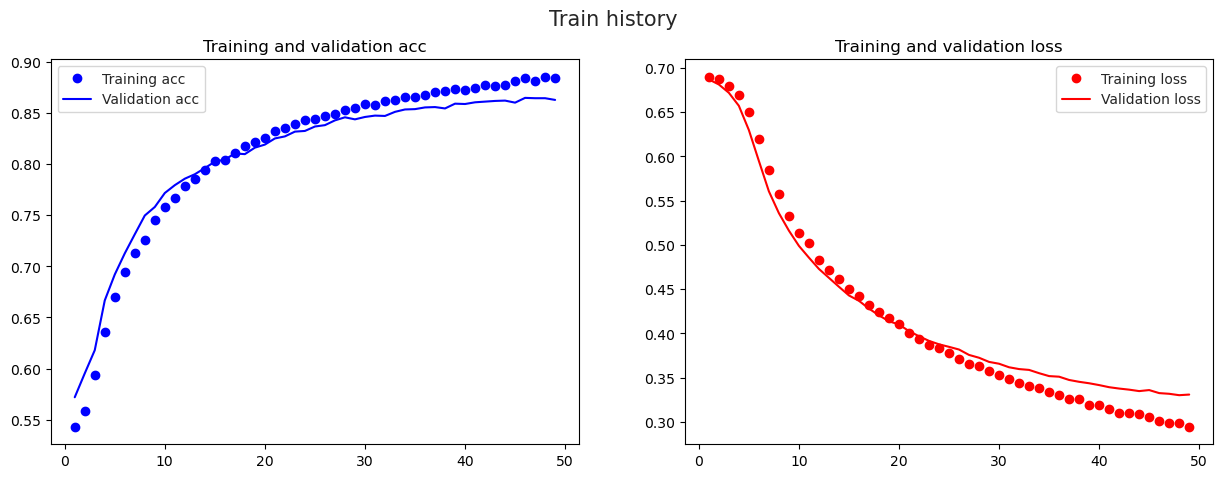

In [16]:
acc = history.history['accuracy'] ##
val_acc = history.history['val_accuracy'] ##
loss = history.history['loss'] ##
val_loss = history.history['val_loss'] ##

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

## 模型评估

In [17]:
model.evaluate(test_padding,y_test) ## 对测试集评估

94/94 [==============================] - 1s 8ms/step - loss: 0.3310 - accuracy: 0.8627


[0.33104512095451355, 0.862666666507721]

In [18]:
# 预测测试标签
predict = model.predict(test_padding) ## 预测测试集标签
predict = predict.argmax(axis=1) # 按行求最大值所在行索引（索引恰好是类别）
predict

array([0, 1, 1, ..., 1, 0, 1])

In [19]:
# 真实测试标签
y_true = y_test.argmax(axis=1) # 按行求最大值所在行索引（索引恰好是类别）
y_true

array([0, 1, 1, ..., 1, 0, 1])

真实值： Counter({1: 1537, 0: 1463})
预测值： Counter({1: 1603, 0: 1397})


<AxesSubplot:>

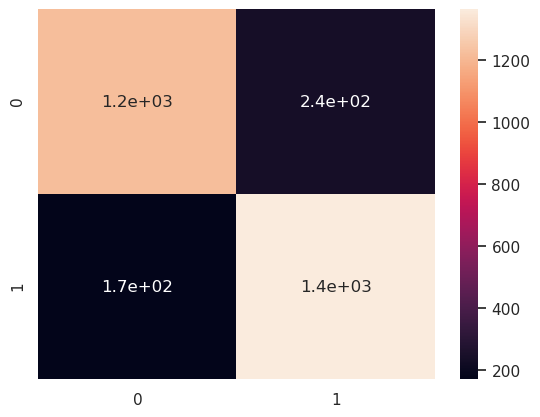

In [20]:
#进行预测


print("真实值：",Counter(y_true)) #真实值统计
print("预测值：",Counter(predict)) #预测值统计

sns.set()
confmat= confusion_matrix(y_true=y_true,y_pred=predict) ## 输出混淆矩阵
sns.heatmap(confmat,annot=True) ## 绘制热度图